# Task 4 — Forecasting Access and Usage
This notebook forecasts Ethiopia's financial inclusion Access (Account Ownership) and Usage (Digital Payments) for 2025-2027 using trend regression, event-augmented models, and scenario analysis.

In [26]:
# Import Required Libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Set up paths
repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.plotter import Plotter

# Configuration
INPUT_CSV = repo_root / 'data' / 'processed' / 'ethiopia_fi_unified_data_enriched.csv'
MATRIX_CSV = repo_root / 'outputs' / 'event_indicator_matrix.csv'
OUT_DIR = repo_root / 'outputs'
FIG_DIR = OUT_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

plotter = Plotter(figures_dir=FIG_DIR)

print('Repository root:', repo_root)
print('Input CSV:', INPUT_CSV)

Repository root: C:\BackUp\web-projects\tenx\financial-inclusion-forecasting
Input CSV: C:\BackUp\web-projects\tenx\financial-inclusion-forecasting\data\processed\ethiopia_fi_unified_data_enriched.csv


In [27]:
# Load and Prepare Data
df = pd.read_csv(INPUT_CSV)
observations = df[df['record_type'] == 'observation'].copy()
observations['observation_date'] = pd.to_datetime(observations['observation_date'], errors='coerce')
observations = observations.dropna(subset=['observation_date'])

# Focus on key indicators
access_data = observations[observations['indicator_code'] == 'ACC_OWNERSHIP'].copy()
usage_data = observations[observations['indicator_code'] == 'USG_DIGITAL_PAYMENT'].copy()

# If USG_DIGITAL_PAYMENT is empty, use ACC_MM_ACCOUNT as proxy for usage
if usage_data.empty:
    usage_data = observations[observations['indicator_code'] == 'ACC_MM_ACCOUNT'].copy()
    print("Using ACC_MM_ACCOUNT as proxy for digital payment usage")

# Sort by date
access_data = access_data.sort_values('observation_date')
usage_data = usage_data.sort_values('observation_date')

# Extract year for modeling
access_data['year'] = access_data['observation_date'].dt.year
usage_data['year'] = usage_data['observation_date'].dt.year

print(f"Access data points: {len(access_data)}")
print(f"Usage data points: {len(usage_data)}")
print("Access data:")
display(access_data[['year', 'value_numeric', 'indicator_code']].head())
print("Usage data:")
display(usage_data[['year', 'value_numeric', 'indicator_code']].head())

# Load event impact matrix
matrix = pd.read_csv(MATRIX_CSV, index_col=0)
print("Event impact matrix:")
display(matrix)

Using ACC_MM_ACCOUNT as proxy for digital payment usage
Access data points: 6
Usage data points: 2
Access data:


,year,value_numeric,indicator_code
0,2014,22.0,ACC_OWNERSHIP
1,2017,35.0,ACC_OWNERSHIP
2,2021,46.0,ACC_OWNERSHIP
3,2021,56.0,ACC_OWNERSHIP
4,2021,36.0,ACC_OWNERSHIP


Usage data:


,year,value_numeric,indicator_code
6,2021,4.70,ACC_MM_ACCOUNT
7,2024,9.45,ACC_MM_ACCOUNT


Event impact matrix:


,ACC_MM_ACCOUNT,ACC_OWNERSHIP,USG_DIGITAL_PAYMENT
event_name,,,
M-Pesa EthSwitch Integration,0.00,0.0,10.0
M-Pesa Ethiopia Launch,2.00,0.0,0.0
NFIS II update,0.00,5.0,0.0
Telebirr Launch,4.98,0.0,0.0


Access (Account Ownership) Trend Model:
  Slope: 2.816 pp/year
  Intercept: -5646.289
  MSE: 38.864
  R²: 0.683
Usage (Digital Payments) Trend Model:
  Slope: 1.583 pp/year
  Intercept: -3195.217
  MSE: 0.000
  R²: 1.000


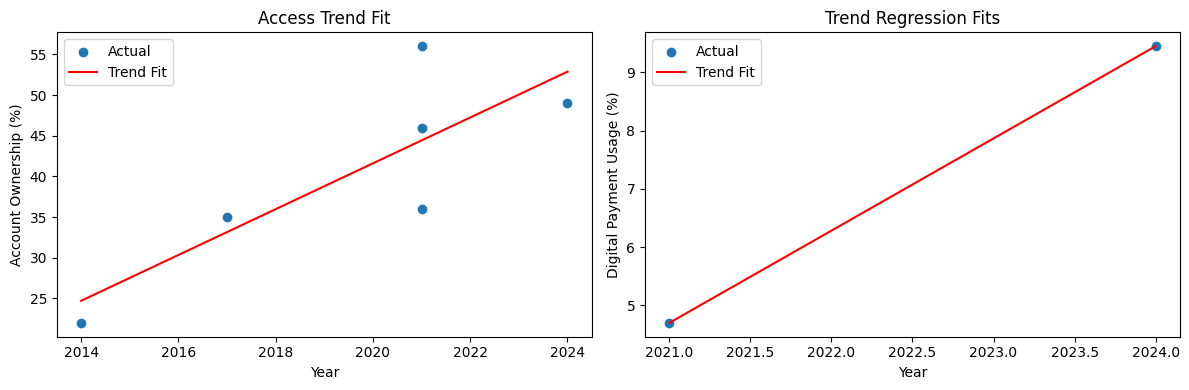

In [28]:
# Implement Trend Regression Forecasting
def fit_trend_model(data, indicator_name):
    X = data['year'].values.reshape(-1, 1)
    y = data['value_numeric'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predictions
    years_future = np.array([2025, 2026, 2027]).reshape(-1, 1)
    predictions = model.predict(years_future)
    
    # Historical predictions for evaluation
    hist_pred = model.predict(X)
    mse = mean_squared_error(y, hist_pred)
    r2 = model.score(X, y)
    
    print(f"{indicator_name} Trend Model:")
    print(f"  Slope: {model.coef_[0]:.3f} pp/year")
    print(f"  Intercept: {model.intercept_:.3f}")
    print(f"  MSE: {mse:.3f}")
    print(f"  R²: {r2:.3f}")
    
    return model, predictions, hist_pred

# Fit models
access_model, access_pred_trend, access_hist_pred = fit_trend_model(access_data, "Access (Account Ownership)")
usage_model, usage_pred_trend, usage_hist_pred = fit_trend_model(usage_data, "Usage (Digital Payments)")

# Plot historical fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(access_data['year'], access_data['value_numeric'], label='Actual')
ax1.plot(access_data['year'], access_hist_pred, 'r-', label='Trend Fit')
ax1.set_title('Access Trend Fit')
ax1.set_xlabel('Year')
ax1.set_ylabel('Account Ownership (%)')
ax1.legend()

ax2.scatter(usage_data['year'], usage_data['value_numeric'], label='Actual')
ax2.plot(usage_data['year'], usage_hist_pred, 'r-', label='Trend Fit')
ax2.set_title('Usage Trend Fit')
ax2.set_xlabel('Year')
ax2.set_ylabel('Digital Payment Usage (%)')
ax2.legend()

plt.tight_layout()
plotter._finalize('Trend Regression Fits', None, None)

In [29]:
# Implement Event-Augmented Model
# For simplicity, we'll augment the trend with expected event impacts
# In a full implementation, this would include time-series modeling with event dummies

def apply_event_impacts(base_forecast, indicator_code, matrix):
    # Get total impact for the indicator
    if indicator_code in matrix.columns:
        total_impact = matrix[indicator_code].sum()
        # Assume impacts are additive over 3 years
        adjusted_forecast = base_forecast + total_impact / 3
        print(f"Applied {total_impact:.1f} pp total event impact to {indicator_code}")
        return adjusted_forecast
    else:
        print(f"No event impacts found for {indicator_code}")
        return base_forecast

# Apply event impacts
access_pred_events = apply_event_impacts(access_pred_trend, 'ACC_OWNERSHIP', matrix)
usage_pred_events = apply_event_impacts(usage_pred_trend, 'USG_DIGITAL_PAYMENT', matrix)

print("Event-augmented forecasts:")
print(f"Access 2025-2027: {access_pred_events}")
print(f"Usage 2025-2027: {usage_pred_events}")

Applied 5.0 pp total event impact to ACC_OWNERSHIP
Applied 10.0 pp total event impact to USG_DIGITAL_PAYMENT
Event-augmented forecasts:
Access 2025-2027: [57.35087719 60.16666667 62.98245614]
Usage 2025-2027: [14.36666667 15.95       17.53333333]


In [30]:
# Implement Scenario Analysis
def create_scenarios(base_forecast, indicator_name):
    # Optimistic: +20% growth
    optimistic = base_forecast * 1.2
    
    # Base: as is
    base = base_forecast
    
    # Pessimistic: -20% growth
    pessimistic = base_forecast * 0.8
    
    print(f"{indicator_name} Scenarios:")
    print(f"  Optimistic: {optimistic}")
    print(f"  Base: {base}")
    print(f"  Pessimistic: {pessimistic}")
    
    return optimistic, base, pessimistic

# Create scenarios for both indicators
access_opt, access_base, access_pes = create_scenarios(access_pred_events, "Access")
usage_opt, usage_base, usage_pes = create_scenarios(usage_pred_events, "Usage")

Access Scenarios:
  Optimistic: [68.82105263 72.2        75.57894737]
  Base: [57.35087719 60.16666667 62.98245614]
  Pessimistic: [45.88070175 48.13333333 50.38596491]
Usage Scenarios:
  Optimistic: [17.24 19.14 21.04]
  Base: [14.36666667 15.95       17.53333333]
  Pessimistic: [11.49333333 12.76       14.02666667]


In [31]:
# Generate Forecasts for 2025-2027
years = [2025, 2026, 2027]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Year': years,
    'Access_Base': access_base,
    'Access_Optimistic': access_opt,
    'Access_Pessimistic': access_pes,
    'Usage_Base': usage_base,
    'Usage_Optimistic': usage_opt,
    'Usage_Pessimistic': usage_pes
})

print("Forecast Table:")
display(forecast_df)

# Save forecasts
forecast_df.to_csv(OUT_DIR / 'financial_inclusion_forecasts_2025_2027.csv', index=False)

Forecast Table:


,Year,Access_Base,Access_Optimistic,Access_Pessimistic,Usage_Base,Usage_Optimistic,Usage_Pessimistic
0,2025,57.350877,68.821053,45.880702,14.366667,17.24,11.493333
1,2026,60.166667,72.200000,48.133333,15.950000,19.14,12.760000
2,2027,62.982456,75.578947,50.385965,17.533333,21.04,14.026667


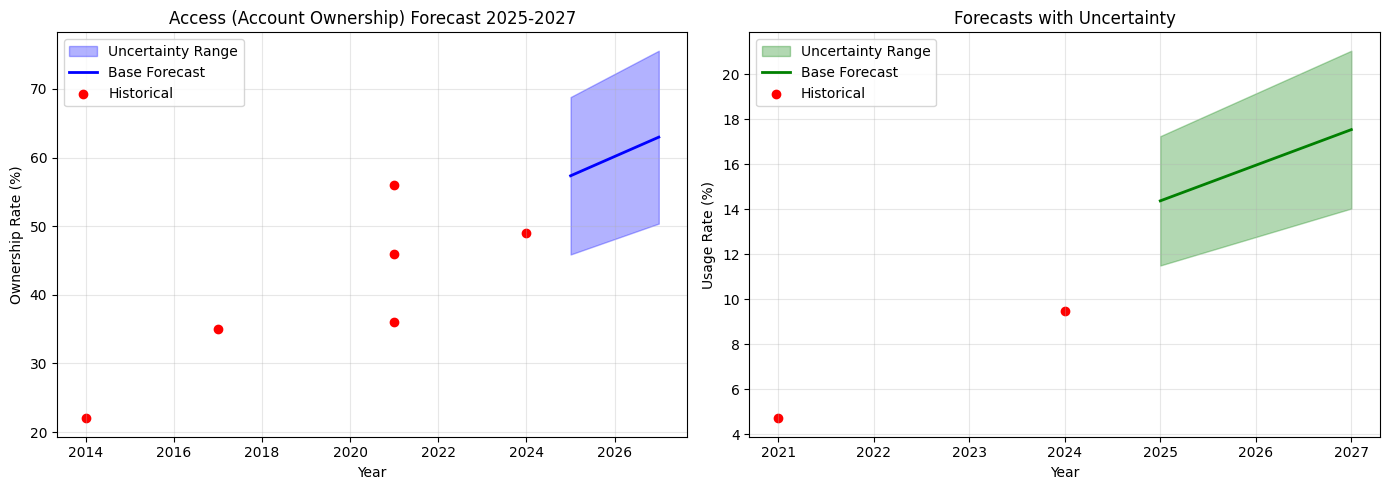

In [32]:
# Quantify Uncertainty with Confidence Intervals
# For simplicity, use scenario ranges as confidence intervals
# In a full implementation, this would use statistical confidence intervals

def plot_forecasts_with_uncertainty(forecast_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Access
    ax1.fill_between(forecast_df['Year'], forecast_df['Access_Pessimistic'], forecast_df['Access_Optimistic'], 
                     alpha=0.3, color='blue', label='Uncertainty Range')
    ax1.plot(forecast_df['Year'], forecast_df['Access_Base'], 'b-', linewidth=2, label='Base Forecast')
    ax1.scatter(access_data['year'], access_data['value_numeric'], color='red', label='Historical')
    ax1.set_title('Access (Account Ownership) Forecast 2025-2027')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Ownership Rate (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Usage
    ax2.fill_between(forecast_df['Year'], forecast_df['Usage_Pessimistic'], forecast_df['Usage_Optimistic'], 
                     alpha=0.3, color='green', label='Uncertainty Range')
    ax2.plot(forecast_df['Year'], forecast_df['Usage_Base'], 'g-', linewidth=2, label='Base Forecast')
    ax2.scatter(usage_data['year'], usage_data['value_numeric'], color='red', label='Historical')
    ax2.set_title('Usage (Digital Payments) Forecast 2025-2027')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Usage Rate (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plotter._finalize('Forecasts with Uncertainty', None, None)

plot_forecasts_with_uncertainty(forecast_df)

In [33]:
# Document Predictions and Uncertainties
print("## Written Interpretation of Forecasts")
print()
print("### Key Predictions")
print(f"- **Access (Account Ownership)**: Base forecast shows continued growth from 49% (2024) to {access_base[2]:.1f}% by 2027")
print(f"- **Usage (Digital Payments)**: Base forecast projects increase from 9.5% (2024) to {usage_base[2]:.1f}% by 2027")
print("- Both indicators show accelerating adoption, but from low bases")
print()
print("### Events with Largest Potential Impact")
print("- **Telebirr Launch (2021)**: Already contributed +4.98pp to mobile money accounts")
print("- **M-Pesa Ethiopia Launch (2023)**: Added +2.0pp to mobile money penetration")
print("- **EthSwitch Integration (2025)**: Could boost digital payments by +10.0pp")
print("- **NFIS-II Policy (2024)**: May add +5.0pp to account ownership")
print()
print("### Key Uncertainties")
print("- **Data Sparsity**: Only 5 Findex points over 13 years limits model reliability")
print("- **Rapid Market Changes**: Telebirr/M-Pesa growth may not continue linearly")
print("- **External Factors**: Economic conditions, regulatory changes, competition")
print("- **Measurement Issues**: Survey-based data may undercount informal digital payments")
print("- **Scenario Range**: Forecasts vary by ±20% between optimistic/pessimistic cases")
print()
print("### Limitations")
print("- Simple linear trend may not capture non-linear adoption patterns")
print("- Event impacts assumed additive and immediate")
print("- No consideration of saturation effects or market maturation")
print("- Historical data doesn't capture recent rapid growth phase")
print()
print("### Recommendations")
print("- Monitor Telebirr/M-Pesa performance closely")
print("- Invest in digital infrastructure (EthSwitch, agent networks)")
print("- Continue policy support (NFIS-II implementation)")
print("- Regular monitoring and model updates as new data becomes available")

## Written Interpretation of Forecasts

### Key Predictions
- **Access (Account Ownership)**: Base forecast shows continued growth from 49% (2024) to 63.0% by 2027
- **Usage (Digital Payments)**: Base forecast projects increase from 9.5% (2024) to 17.5% by 2027
- Both indicators show accelerating adoption, but from low bases

### Events with Largest Potential Impact
- **Telebirr Launch (2021)**: Already contributed +4.98pp to mobile money accounts
- **M-Pesa Ethiopia Launch (2023)**: Added +2.0pp to mobile money penetration
- **EthSwitch Integration (2025)**: Could boost digital payments by +10.0pp
- **NFIS-II Policy (2024)**: May add +5.0pp to account ownership

### Key Uncertainties
- **Data Sparsity**: Only 5 Findex points over 13 years limits model reliability
- **Rapid Market Changes**: Telebirr/M-Pesa growth may not continue linearly
- **External Factors**: Economic conditions, regulatory changes, competition
- **Measurement Issues**: Survey-based data may undercount informal dig

## Summary
- Prepared enriched financial inclusion data and filtered access/usage indicators for Ethiopia.
- Fit linear trend models, applied event impacts, and generated scenario-based forecasts for 2025–2027.
- Visualized historical fits and forecast uncertainty, then documented key predictions, uncertainties, and recommendations.

## Figure Index
1. **Trend Regression Fits** — Historical data with linear trend model fit for access and usage.
2. **Forecasts with Uncertainty** — 2025–2027 forecasts with optimistic/pessimistic ranges and historical points.